In [22]:
# K-Nearest Neighbour Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import bias_variance_decomp
sns.set()
%matplotlib inline

In [3]:
# Reading the data

loans = pd.read_csv('lending_club_loan.csv')

In [4]:
# function to fill in missing values of mort_acc

def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [5]:
# feature engineering

loans['loan_repaid'] = loans['loan_status'].map({'Fully Paid':1,'Charged Off':0})
total_acc_avg = loans.groupby('total_acc').mean()['mort_acc']
loans['mort_acc'] = loans.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

#categorical variables
loans['term'] = loans['term'].apply(lambda term: int(term[:3]))
loans['home_ownership']=loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
loans['zip_code'] = loans['address'].apply(lambda address:address[-5:])
loans['earliest_cr_year'] = loans['earliest_cr_line'].apply(lambda date:int(date[:4]))

dummies = pd.get_dummies(loans[['zip_code','home_ownership','grade','verification_status', 'application_type','initial_list_status','purpose' ]],drop_first=True)
loans = loans.drop(['zip_code','address', 'home_ownership', 'grade','verification_status', 'application_type','initial_list_status','purpose'],axis=1)
loans = pd.concat([loans,dummies],axis=1)

loans = loans.drop(['emp_title','emp_length','title','sub_grade', 'issue_d', 'earliest_cr_line', 'loan_status'],axis=1)
loans = loans.dropna()

In [6]:
# Removing labels from dataset

X = loans.drop('loan_repaid',axis=1).values
y = loans['loan_repaid'].values

In [7]:
# Train-test-validation split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [8]:
# Normalizing the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
# Baseline KNN model

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_val)

In [10]:
# classification accuracies on validation data

print(classification_report(y_val, pred))
print('\n Accuracy of Baseline model: ', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1444
           1       0.89      0.89      0.89      6042

    accuracy                           0.83      7486
   macro avg       0.72      0.72      0.72      7486
weighted avg       0.83      0.83      0.83      7486


 Accuracy of Baseline model:  0.8268768367619557


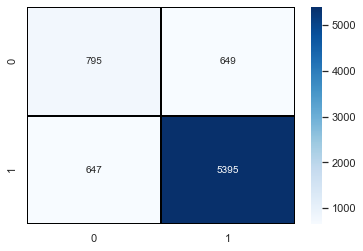

In [11]:
# confusion matrix of validation data

sns.heatmap(confusion_matrix(y_val, pred), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [12]:
# F1 score and Area under Precision-Recall Curve

knn_probs = knn.predict_proba(X_val)
knn_probs = knn_probs[:, 1]
knn_precision, knn_recall, _ = precision_recall_curve(y_val, knn_probs)
knn_f1, knn_auc = f1_score(y_val, pred), auc(knn_recall, knn_precision)
print('KNN Model: F1 Score = %.3f PR-AUC = %.3f' % (knn_f1, knn_auc))

KNN Model: F1 Score = 0.893 PR-AUC = 0.936


In [13]:
# finding best K value

error_rate = []
for i in range(1,21):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_val)
    error_rate.append(np.mean(pred_i != y_val))

Text(0, 0.5, 'Error Rate')

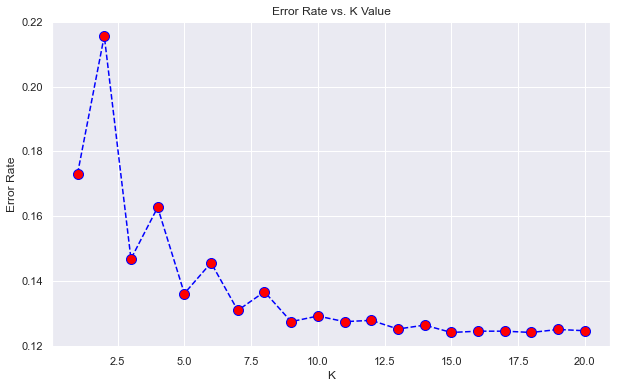

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [15]:
# Final Model with K = 15

knn_final = KNeighborsClassifier(n_neighbors=15)
knn_final.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=15)

In [16]:
# classification accuracy on validation data

pred = knn_final.predict(X_val)
print(classification_report(y_val, pred))
print('\n Accuracy: ', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

           0       0.88      0.41      0.56      1444
           1       0.88      0.99      0.93      6042

    accuracy                           0.88      7486
   macro avg       0.88      0.70      0.74      7486
weighted avg       0.88      0.88      0.86      7486


 Accuracy:  0.8759016831418648


In [17]:
# classification accuracy on test data

prediction = knn_final.predict(X_test)
print(classification_report(y_test, prediction))
print('\n Accuracy: ', accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      0.39      0.54      1395
           1       0.88      0.99      0.93      6092

    accuracy                           0.87      7487
   macro avg       0.87      0.69      0.73      7487
weighted avg       0.87      0.87      0.86      7487


 Accuracy:  0.8749833043942834


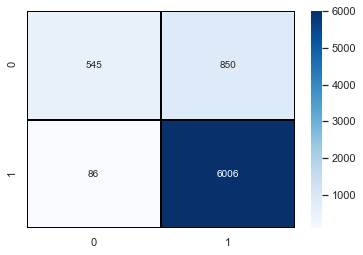

In [18]:
# confusion matrix of test data

sns.heatmap(confusion_matrix(y_test, prediction), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [19]:
# F1 score and Area under Precision-Recall Curve for test data

knn_probs = knn_final.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_probs)
knn_f1, knn_auc = f1_score(y_test, prediction), auc(knn_recall, knn_precision)
print('KNN Model: F1 Score = %.3f PR-AUC = %.3f' % (knn_f1, knn_auc))

KNN Model: F1 Score = 0.928 PR-AUC = 0.963


In [20]:
# Bias and Variance of the model

mse, bias, var = bias_variance_decomp(knn_final, X_train, y_train, X_test, y_test, loss='mse', num_rounds=10, random_seed=1)
print('average MSE: %.3f' % mse)
print('average Bias: %.3f' % bias)
print('average Variance: %.3f' % var)

average MSE: 0.136
average Bias: 0.110
average Variance: 0.026
